<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/BetterTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [1]:


# tfds.disable_progress_bar()

# train_ds, validation_ds, test_ds = tfds.load(
#     "cats_vs_dogs",
#     # Reserve 10% for validation and 10% for test
#     split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
#     as_supervised=True,  # Include labels
# )

# print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
# print(
#     "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
# )
# print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete54FYG6/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


NameError: ignored

In [ ]:
df = pd.read_csv('data/train_labels.csv')
path = 'data/train_set/train_set/'

X = path+df.img_name.values
y = df.label.values - 1
print(X)
print(y)

In [ ]:
from sklearn.model_selection import train_test_split

train, test, train_y, test_y = train_test_split(X, y, train_size=0.5, test_size=0.1, random_state=1)
train, val, train_y, val_y = train_test_split(train, train_y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

num_classes = 80
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

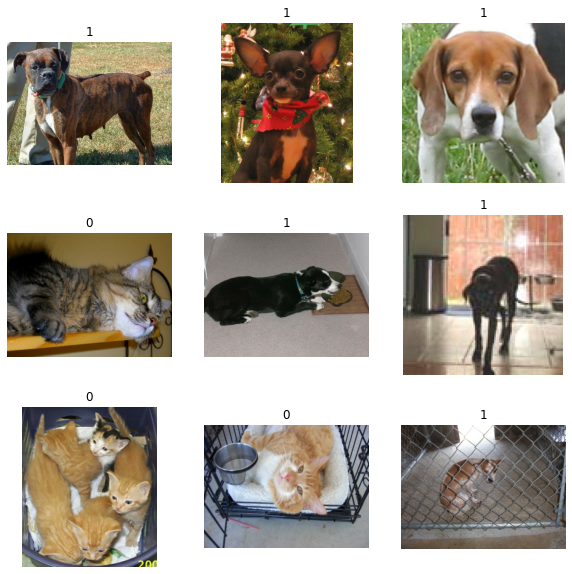

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

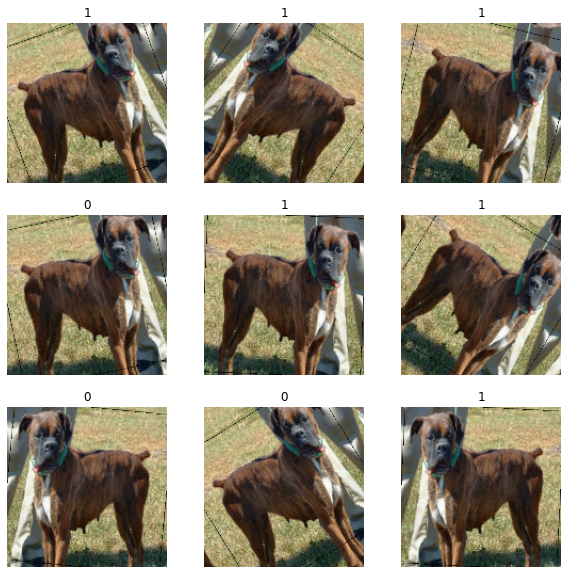

In [7]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_______________________________________________________

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 10s 34ms/step - loss: 0.1032 - binary_accuracy: 0.9577 - val_loss: 0.0820 - val_binary_accuracy: 0.9699
Epoch 2/10
291/291 [==============================] - 9s 32ms/step - loss: 0.1089 - binary_accuracy: 0.9553 - val_loss: 0.0788 - val_binary_accuracy: 0.9690
Epoch 3/10
291/291 [==============================] - 9s 32ms/step - loss: 0.1036 - binary_accuracy: 0.9571 - val_loss: 0.0811 - val_binary_accuracy: 0.9703
Epoch 4/10
291/291 [==============================] - 9s 32ms/step - loss: 0.1079 - binary_accuracy: 0.9556 - val_loss: 0.0758 - val_binary_accuracy: 0.9690
Epoch 5/10
291/291 [==============================] - 9s 32ms/step - loss: 0.0988 - binary_accuracy: 0.9612 - val_loss: 0.0824 - val_binary_accuracy: 0.9695
Epoch 6/10
291/291 [==============================] - 9s 32ms/step - loss: 0.1015 - binary_accuracy: 0.9609 - val_loss: 0.0845 - val_binary_accuracy: 0.9686
Epoch 7/10
291/291 [==============================] - 9s 

In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

291/291 [==============================] - 40s 137ms/step - loss: 0.0818 - binary_accuracy: 0.9670 - val_loss: 0.0506 - val_binary_accuracy: 0.9768
Epoch 2/10
291/291 [==============================] - 39s 134ms/step - loss: 0.0601 - binary_accuracy: 0.9759 - val_loss: 0.0448 - val_binary_accuracy: 0.9802
Epoch 3/10
291/291 [==============================] - 39s 134ms/step - loss: 0.0429 - binary_accuracy: 0.9841 - val_loss: 0.0496 - val_binary_accuracy: 0.9802
Epoch 4/10
291/291 [==============================] - 39s 134ms/step - loss: 0.0427 - binary_accuracy: 0.9837 - val_loss: 0.0469 - val_binary_accuracy: 0.9802
Epoch 5/10
291/291 [==============================] - 39s 134ms/step - loss: 0.0294 - binary_accuracy: 0.9890 - val_loss: 0.0423 - val_binary_accuracy: 0.9824
Epoch 6/10
291/291 [==============================] - 39s 134ms/step - loss: 0.0204 - binary_accuracy: 0.9934 - val_loss: 0.0481 - val_binary_accuracy: 0.9841
Epoch 7/10
291/291 [==============================] - 39s